# 0. Introduction

### Tutorial outline
This is a tutorial for using FUNCOIN (Functional Connectivity Integrative Normative Modelling) with the python module funcoin as described in Kobbersmed et al. The tutorial is structured as follows: After a short introduction to the method, we first simulate time series data following the scheme proposed in Zhao et al (2021). To illustrate how to use the model, we then use FUNCOIN to analyse the simulated data. 

The data simulation process is a way of getting more familiar with the model. For only an introduction to using the module itself, you can run the first blocks of code and start reading the turorial from section 2.

### The FUNCOIN method
The method is an adaptation of Covariate-Assisted Principal Regression (Zhao et al. 2021) to a normative modelling framework. The method (and this module) is not specific for normative modelling and can be used for covariance/functional connectivity regression in general.

In brief, the method is similar to finding principal components  shared among a group of subjects. Here, instead of finding the components explaining most variance, we integratively identify components and do regression by finding the components that dependent most on covariates specified in the feature matrix *X*. Like with PCA, these components can be found sequentially, with the component most associated with covariates being identified first.

Mathematically, we find $\gamma_j$ projections such that
\begin{align*}
    u_{j,i} = \log(\gamma_j^{\top} \Sigma_i \gamma_j) = \beta_0 + x_i^{\top}\beta 
\end{align*}
where $\beta_0\in\mathbb{R}$ is the intercept, $\beta \in \mathbb{R}^{q-1}$ are model coefficients, and $x_i\in\mathbb{R}^{q-1}$ is the vector of q-1 covariates of subject i.

In the FUNCOIN adaptation we assume that the residuals in this model are normally distributed with homogenous variance, which allows a more precise estimation of the beta coefficients.


In [1]:
#Import dependencies
import numpy as np
from matplotlib import pyplot as plt
from funcoin import Funcoin

# 1. Generating example data

### Setting parameters

In the foolowing we define parameters relevant for the simulation.  
In this simulatino we have *p*=5 (5 dimensions of time series data). A well-known application of this method is in functional connectivity in e.g. brain fMRI, in which case *p* is the number of brain regions.
We have *q*=2, which means we have 2 features in the X matrix (including intercept). In this simulation, X<sub>1</sub> is 0 or 1. A familiar example would be the binary coding of subject's sex.

In [2]:
n_subj = 200 # Number of subjects
T = 100 # Number of time points.

# Defining the gamma matrix used in the simulation study in Zhao et al (2021). 
# The gamma matrix is in general of size p x m with m being the number of projections found/defined.
gamma_true = np.array([[0.447, 0.447, 0.447, 0.447, 0.447], 
                      [0.447, -0.862, 0.138, 0.138, 0.138],
                      [0.447, 0.138, -0.862, 0.138, 0.138],
                      [0.447, 0.138, 0.138, -0.862, 0.138],
                      [0.447, 0.138, 0.138, 0.138, -0.862]])

# Defining the beta matrix used in the simulation study in Zhao et al (2021). 
# The beta matrix is of size q x p (here 2x5).
beta_true = np.array([[5, 4, 1, -1, -2],
                     [0, -1, 1, 0, 0]])

# Simulating subject features/covariates.
seed = 1
rng = np.random.default_rng(seed=seed)
X1s = rng.binomial(1,0.5,n_subj)

X_sim = np.array([np.ones(n_subj), X1s]).T #X_sim is of size n_subj x q (here 100 x 2). X_0 is the intercept. In this casae X_1 is a categorical variable (0 or 1).


### Simulating data

With the class method called simulate_data, we generate time series data from predefined Gamma and Beta matrices as well as the covariate matrix (X_sim).

In [3]:
seed = 12
funcoin_true = Funcoin(gamma = gamma_true, beta=beta_true)

Y_sim = funcoin_true.simulate_data(X_dat = X_sim, n_T=T, seed=seed)

print(f'Number of subjects: {len(Y_sim)}')
print(f'Shape of each subject\'s data: {Y_sim[0].shape}')


Simulating data using predefined Gamma and Beta matrices.
Number of subjects: 200
Shape of each subject's data: (100, 5)


Y_sim is a list of time series data for each subject. The shape of each element is T x p (number of time points by number of regions/time series sources.)

Note that it would be possible to generate data with a Gamma matrix of size p-by-m with m&lt;p. In that case, the covariance matrix used for the time series simulation would be of rank m, i.e. the eigenspace would be of dimension lower than p. 

The following plots show the simulated data for subject 0:


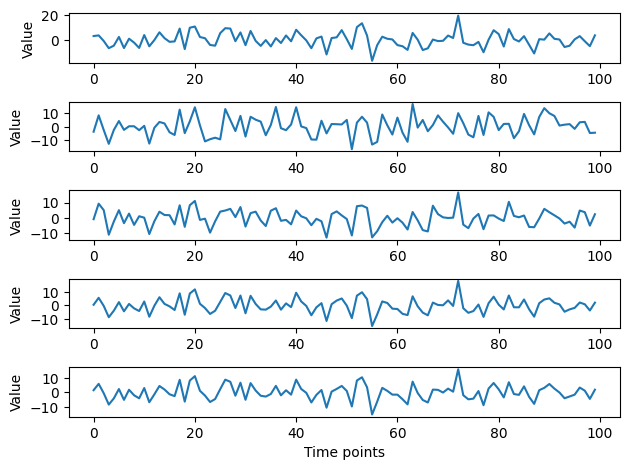

In [4]:
fig, ax = plt.subplots(Y_sim[0].shape[1],1)
for i in range(5):
    ax[i].plot(np.arange(T), Y_sim[0][:,i])
    ax[i].set_ylabel('Value')

ax[4].set_xlabel('Time points')
plt.tight_layout()
plt.show()


# 2. FUNCOIN decomposition of the simulated data

Having generated time series data for each subject, we now show how to use the FUNCOIN module on existing data. Given X (N-by-q feature matrix) and Y (time series data provided as a list of matrices of size T<sub>i</sub>-by-q), we can run the FUNCOIN decomposition. Note that the method allows for the number of time points being different among subjects (hence the subscript in T<sub>i</sub>).

We identify the two first components with FUNCOIN (if betaLinReg is set to False, the fitting routine from the original method (Zhao et al. 2021) is used):

In [5]:
max_comps = 2

funcoin_new = Funcoin()
print('Is model fitted already?')
print(funcoin_new.isfitted()) # Check if the model has been fitted already. Distinguishes non-defined or predefined vs fitted Gamma and Beta.
print('\nRunning decomposition')
funcoin_new.decompose(Y_dat=Y_sim, X_dat=X_sim, max_comps=max_comps, betaLinReg=True)
print('\nIs model fitted now?')
print(funcoin_new.isfitted()) # The model is now fitted.

Is model fitted already?
False

Running decomposition

Is model fitted now?
True


The transformed data ($u_i$ values) are stored when running the decomposition. These will be a 2d array of size n_subj x n_comps.

In [6]:
u_training = funcoin_new.u_training
print('u values for the first 5 subjects:')
print(u_training[:5,:])

u values for the first 5 subjects:
[[1.82902179 2.7880647 ]
 [2.1718424  2.55274693]
 [0.76381833 3.87423319]
 [2.1629511  2.87848487]
 [0.74697621 3.72466483]]


In the above, we specify max_comps = 2, which means that the algorithm stops after identifying 2 projection directions. It may happen that this is not possible, in which case the algorithm will return fewer projections. We can try to identify up to q directions. A method for determining the number of projections to consider is described below.

Several other parameters (e.g. tolerance, seed of initial conditions, number of initial conditions, whether to trace solutions from the optimum search algorithm etc.) can be set when calling the decompose method (see method documentation). In this tutorial, the method is run with the default settings (finding best fit from 20 random initial conditions with at most 1000 iteration and tolerance 1e-4).


# 3. Analysis of model fit

The funcoin object has now been fitted with the data provided. The identified gamma projections as well as the coefficients are accesible as instance variables of the class instance:

In [7]:
gamma_fitted = funcoin_new.gamma
beta_fitted = funcoin_new.beta

print('Gamma matrix:')
print(gamma_fitted)
print('\nBeta matrix:')
print(beta_fitted)

Gamma matrix:
[[ 0.37345586  0.24744439]
 [ 0.10997053 -0.81252826]
 [-0.87653539  0.12151674]
 [ 0.18331435 -0.03825172]
 [ 0.21568209  0.51219096]]

Beta matrix:
[[ 0.95803308  3.75439313]
 [ 0.99804797 -0.9823031 ]]


The number of projections to indentify is a crucial parameter. In Zhao et al (2021), a data-driven approach for choosing the number of projections to keep is suggested. We compute the average "deviation from diagonality" (see Kobbersmed et al (2024) and Zhao et al (2021)) for each number of projections and either threshold this value or look for a sudden large increase in average dfd value to determine a reasonable number of components to keep. 

The average dfd values of the training set are computed and stored after the fitting process and stored as an instance variable:

REMEMBER TO PROVIDE CORRECT CITATION ABOVE

In [8]:
print(funcoin_new.dfd_values_training)


[np.float64(1.0), np.float64(1.0125157950022587)]


Each gamma projection identified projects the covariance/correlation matrix into a 1-dimensional space (similar to PCA components). We can apply this transformation to the training data or to out-of-sample data with equal dimensions. 
The transformation applied is:
$$
    u_{j,i} = \log(\gamma_j \Sigma_i \gamma_j^T)
$$
with $\gamma_j$ being projection $j$ and $\Sigma_i$ being the correlation matrix of subject $i$. 

We now plot the transformed values (i.e. using the two identified $\gamma_j$ projections) from the training data:

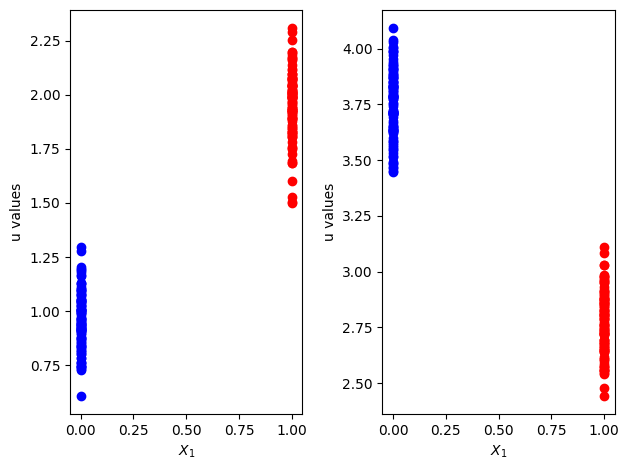

In [9]:
u_training = funcoin_new.u_training

fig, ax = plt.subplots(1,max_comps)
for i in range(max_comps):
    
    ax[i].plot(X_sim[X_sim[:,1]==0,1], u_training[X_sim[:,1]==0,i], 'bo')
    ax[i].plot(X_sim[X_sim[:,1]==1,1], u_training[X_sim[:,1]==1,i], 'ro')
    ax[i].set_xlabel('$X_1$')
    ax[i].set_ylabel('u values')

fig.tight_layout()

Since X<sub>1</sub> is categorical, we see the points group in two point clouds depending on the value of X<sub>1</sub>. Note that the model also works for continuous features/covariates or a mix of categorical and continuous (as in Kobbersmed et al (2024)).

To asses the goodness-of-fit of the log-linear model ($X$, $u_i$), we can compute a range of scores using the .score() method. This returns an array of scores, one for each identified projection. All scores in sklearn.metrics can be utilized (note that some, e.g. root_mean_squared_error are only available for sklearn v1.4+). Any keywords applicable for the chosen score type, e.g. sample_weight, can be used. Note that keyword argument 'multioutput' will be ignored, since this function outputs scores for each projection. Like with sklearn, the score function can be applied to any both training dataset or other data.

In [10]:
#Compute insample scores:
print('Mean absolute error (insample) for the log-linear model of the transformed covariance/correlation matrices:')
MAE_insample = funcoin_new.score(X_sim, u_true=u_training, score_type='mean_squared_error')
print(MAE_insample)

print('Insample R^2 values (default score type):')
R2_insample = funcoin_new.score(X_sim, u_true=u_training, score_type='r2_score')
print(R2_insample)


Mean absolute error (insample) for the log-linear model of the transformed covariance/correlation matrices:
[0.02085219 0.02115217]
Insample R^2 values (default score type):
[0.92273452 0.91938406]


The model is easily evaluated on out-of-sample data. We first simulate out-of-sample data:

In [11]:
#Simulate out-of-sample data from the same model as used above and evaluate scores
seed = 123
n_out = 40
rng = np.random.default_rng(seed=seed)
X1_out = rng.binomial(1,0.5,n_out)
X_out = np.array([np.ones(n_out), X1_out]).T #X_out is of size n_out x q (here 50 x 2). X_0 is the intercept. In this casae X_1 is a categorical variable (0 or 1).

Y_out = funcoin_true.simulate_data(X_out, T, seed = seed)

Simulating data using predefined Gamma and Beta matrices.


If we want the actual transformed values, we can transform an out-of-sample dataset using the Gamma and Beta already found in the fitting procedure. Alternatively, we can transform FC matrices directly (these need to be Pearson full correlation or covariance matrices with n degrees of freedom in line with the training data).

In [12]:
#Transform time series data to u_i using the model already fitted.
u_outsample = funcoin_new.transform_timeseries(Y_out)
#Equivalently, transform the FC matrices
FC_mats = [np.cov(Y_out[i].T, ddof=0) for i in range(len(Y_out))]
u_outsample_eq = funcoin_new.transform_FC(FC_mats)

print(f'Are the two transformations equivalent?')
print(np.all(u_outsample==u_outsample_eq))


Are the two transformations equivalent?
True


We can also evaluate the out-of-sample fit by computing best fit scores like R^2 or MSE either by parsing the time series data or by parsing the transformed values. Being out-of-sample, both the scores and the transformed variables (u values) are outputted from the method and not stored in the funcoin object.

In [13]:
#Evaluate scores on the new data inputting time series data
R2_out = funcoin_new.score(X_out, Y_dat = Y_out, score_type='r2_score')
print('\nOut-of-sample R^2 from time series:')
print(R2_out)

#Alternatively, evaluate scores on the out-of-sample u values instead
R2_out = funcoin_new.score(X_out, u_true= u_outsample, score_type='r2_score')
print('\nOut-of-sample R^2 from u values:')
print(R2_out)


Out-of-sample R^2 from time series:
[0.87707837 0.90816829]

Out-of-sample R^2 from u values:
[0.87707837 0.90816829]


### Calculating Z-scores for normative modelling

In normative modelling, each subject's deviance from the model prediction (given the subject's covariates) is often assessed with the Z-score, i.e. the deviance measured in number of standard deviations from the model prediction. The method calc_Zscores() returns the Z-scores under the assumption that the residuals are normally distributed and homogenous, which should be checked. It is not adviced to calculate the Z-scores after fitting with _betaLinReg set to False, since these model predictions are potentially biased. The same assumptions on the residuals applies for using the method with _betaLinReg_ set to True. 

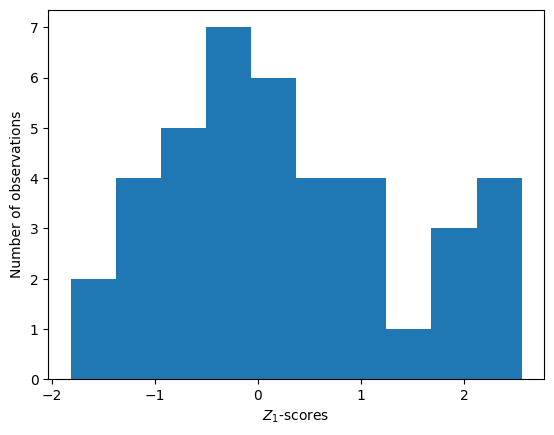

In [14]:
#Calculate out-of-sample Z-scores:
Zscores_outsample = funcoin_new.calc_Zscores(X_out, u_outsample)

plt.hist(Zscores_outsample[:,0])
plt.xlabel('$Z_1$-scores')
plt.ylabel('Number of observations')
plt.show()

# 4. Running funcoin with bootstrapping

To asses confidence intervals of gamma and beta estimations, we can run the decomposition with bootstrapping. This is done by calling the method .decompose_bootstrap, which takes the same arguments as the .decompose method as well as the parameters _n_sample_ and _CI_lvl_. These two parameters control the number of bootstrap samples and the significance level for the confidence intervals (default 0.05). The method first runs regular FUNCOIN decomposition on the data and sets gamma and beta. It then samples with replacement from the data provided to generate a new dataset of the same size as the original dataset and runs the decomposition on the new sample. The reampling and fitting is done _n_samples_ times.

When running .decompose_bootstrap(), the Gamma and Beta matrices from the bootstrapping procedure as well as the elementwise gamma and beta confidence intervals are stored as instance variables. The significance level used in the confidence intervals is also stored. 

Below we demonstrate the usage with only 10 bootstrap samples.

In [15]:
funcoin_bootstrap = Funcoin()
funcoin_bootstrap.decompose_bootstrap(Y_sim, X_sim, n_samples=10, max_comps = 2, CI_lvl = 0.05, seed_bootstrap=1234) #CI_lvl is also 0.05 per default

In [16]:
#The .funcoin_bootstrap() does regular fitting of the model:
print('Is the model fitted?')
print(funcoin_bootstrap.isfitted()) 
print(' ')
#All Beta matrices from bootstrapping are stored in a list of length equal to:
print(f'Number of Beta matrices identified:')
print(len(funcoin_bootstrap.betas_bootstrap)) #Number of bootstrap samples (n_samples) 

#Elementwise confidence intervals of Gamma and Beta are stored as lower and upper limit matrices
print('\nConfidence level:')
print(funcoin_bootstrap.CI_lvl)
print('\nLower border of Beta confidence interval:')
print(funcoin_bootstrap.beta_CI[0])
print('\nUpper border of Beta confidence interval:')
print(funcoin_bootstrap.beta_CI[1])


Is the model fitted?
True
 
Number of Beta matrices identified:
10

Confidence level:
0.05

Lower border of Beta confidence interval:
[[ 0.95034422  3.72663265]
 [ 0.96487284 -1.00779773]]

Upper border of Beta confidence interval:
[[ 0.98592928  3.78331872]
 [ 1.03870516 -0.96503692]]


# References
- Kobbersmed, J.R.L., C. Gohil, A.F. Marquand, and D. Vidaurre, _Normative modelling of brain functional connectivity: a network approach_
- Zhao, Y., B. Wang, S. H. Mostofsky, B. S. Caffo, and X. Luo. 2021. 'Covariate Assisted Principal regression for covariance matrix outcomes', Biostatistics, 22: 629-45.